# Benchmarking Fashion MNIST Dataset on LeNet-5

In [38]:
# Imports
import os
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter


In [39]:
class LeNet5(nn.Module):
    def __init__(self, use_batch_norm=False, use_dropout=False, dropout_prob=0.5):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=[5, 5])
        self.avg_pool1 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=[5, 5])
        self.avg_pool2 = nn.AvgPool2d(kernel_size=[2, 2], stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=[5, 5])
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)
        self.use_batch_norm = use_batch_norm
        self.use_dropout = use_dropout
        if use_batch_norm:
            self.batch_norm1 = nn.BatchNorm2d(6)
            self.batch_norm2 = nn.BatchNorm2d(16)
            self.batch_norm3 = nn.BatchNorm2d(120)
        if use_dropout:
            self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.conv1(x)
        if self.use_batch_norm:
            x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.avg_pool1(x)

        x = self.conv2(x)
        if self.use_batch_norm:
            x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.avg_pool2(x)

        x = self.conv3(x)
        if self.use_batch_norm:
            x = self.batch_norm3(x)
        x = F.relu(x)

        x = torch.flatten(x, 1)
        if self.use_dropout:
            x = self.dropout(x)
        x = F.relu(self.fc1(x))

        x = F.softmax(self.fc2(x), dim=1)
        return x

In [40]:
# Define hyperparameters
batch_size = 64
learning_rate = 0.001
epochs = 100
validation_split = 0.2
weight_decay = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(fr'Using device:{device}')

Using device:cpu


In [41]:
# Load the fashionMNIST dataset
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize each image to 32x32 to fit to Lenet5 original dimensions
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
label_names = train_dataset.classes
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the validation split
train_size = int((1-validation_split) * len(train_dataset))
val_size = len(train_dataset) - train_size

# Split the dataset
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)




# Dataset Visualization

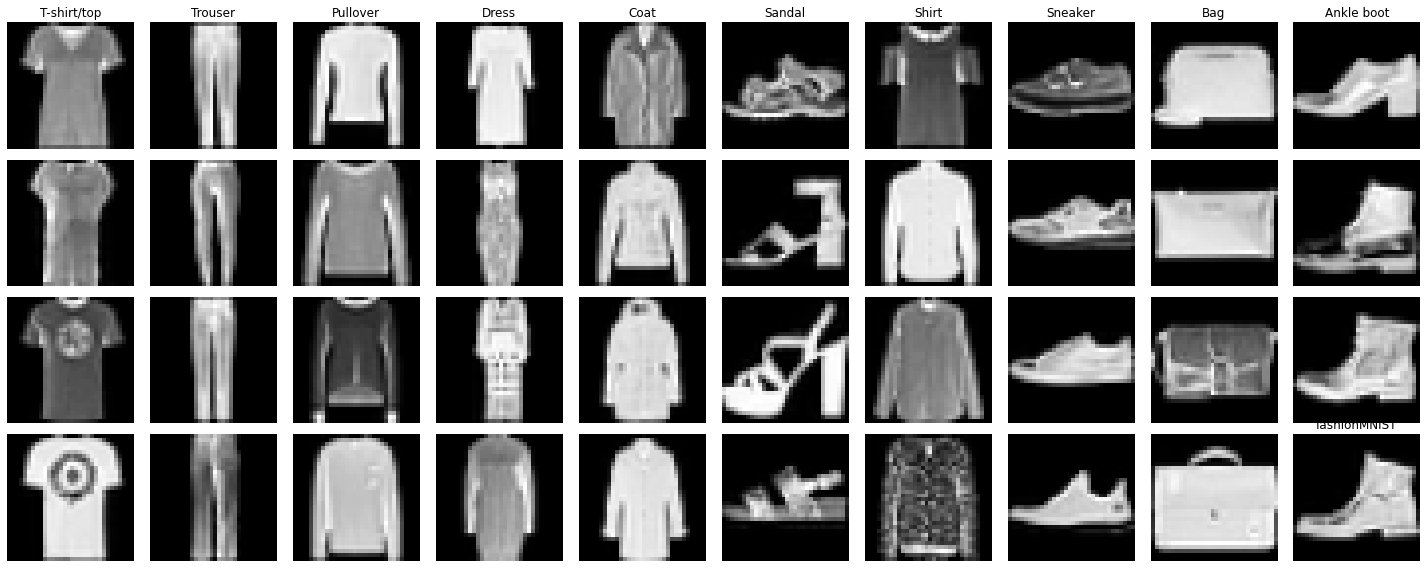

In [42]:
num_samples=4

label_to_images = {i: [] for i in range(10)}


for image, label in train_dataset:
    if len(label_to_images[label]) < num_samples:
        label_to_images[label].append(image)
    if all(len(images) == num_samples for images in label_to_images.values()):
        break

fig, axes = plt.subplots(num_samples, 10, figsize=(20, num_samples * 2))

for label in range(10):
    for i in range(num_samples):
        image = label_to_images[label][i].squeeze().numpy()
        axes[i, label].imshow(image, cmap='gray')
        axes[i, label].axis('off')
        if i == 0:
            axes[i, label].set_title(label_names[label], fontsize=12)

    
plt.tight_layout()
plt.title('fashionMNIST')
plt.show()

In [43]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct_test = 0
    total_test = 0
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_accuracy = 100. * correct_test / total_test
    average_loss = total_loss / len(test_loader)
    return test_accuracy, average_loss


# Define a function to visualize and log test samples with predictions
def log_test_samples(model, test_loader, writer, epoch, num_samples=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        img = images[i].cpu().numpy().squeeze()
        axs[i].imshow(img, cmap='gray')
        axs[i].set_title(f"Pred: {label_names[predicted[i].item()]}\nLabel: {label_names[labels[i].item()]}")
        axs[i].axis('off')
    
    writer.add_figure('Test Samples', fig, epoch)
    
    # Display the plot in the notebook
    plt.show()

In [44]:
def train_and_evaluate(run_name, model, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device, criterion = nn.CrossEntropyLoss()):
    # Add model graph to TensorBoard
    writer = SummaryWriter(fr'runs/{run_name}')
    dummy_input = torch.zeros(batch_size, 1, 32, 32).to(device)
    writer.add_graph(model, dummy_input)
    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        batch_loader = tqdm(train_loader, desc="Batches")
        for images, labels in batch_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Calculate training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            train_accuracy = 100. * correct_train / total_train
            batch_loader.set_description(f"{run_name} Epoch [{epoch+1}/{epochs}] Batch Loss: {loss.item():.4f} Train accuracy: {train_accuracy:.4f}")
        
        # Log the running loss to TensorBoard
        average_loss = running_loss / len(train_loader)
        train_accuracy = 100. * correct_train / total_train
        writer.add_scalar('Loss/Training', average_loss, epoch)
        
        # Log learning rate to TensorBoard
        current_lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning Rate', current_lr, epoch)
        
        validation_accuracy, validation_avg_loss = evaluate_model(model=model, test_loader=val_loader, criterion=criterion)
        
        test_accuracy, _ = evaluate_model(model=model, test_loader=test_loader, criterion=criterion)
        writer.add_scalars(fr'Accuracy/{run_name}', \
                           {'train': train_accuracy, \
                            'test': test_accuracy} \
                                       , epoch)
        
        # Log test samples with predictions to TensorBoard
        log_test_samples(model, test_loader, writer, epoch)
        
        # Step the scheduler and check if learning rate was reduced
        scheduler.step(validation_avg_loss)
        
        # Save the model if validation loss has decreased
        if validation_avg_loss < best_val_loss:
            best_val_loss = validation_avg_loss
            torch.save(model.state_dict(),  f'model_{run_name}.pth')


        batch_loader.set_description(f"{run_name} Epoch [{epoch+1}/{epochs}] Batch Loss: {loss.item():.4f} Train accuracy: {train_accuracy:.4f} Test accuracy: {test_accuracy:.4f}")
        if current_lr<=1e-7:
            # Early stopping, convergence condition
            break

    # Evaluation on the test set
    writer.close()

In [53]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
def extract_scalar_events(logdir, scalar_name):
    event_acc = EventAccumulator(logdir)
    event_acc.Reload()

    events = event_acc.Scalars(scalar_name)
    steps = [event.step for event in events]
    values = [event.value for event in events]
    
    return steps, values

def load_model_and_evaluate(model, run_name):
    model.load_state_dict(torch.load(f'model_{run_name}.pth'))
    test_accuracy, _ = evaluate_model(model=model, test_loader=test_loader, criterion=nn.CrossEntropyLoss())
    print(f'Accuracy of model on test images: {test_accuracy:.2f}%')

    logdir_test = fr'runs\{run_name}\Accuracy_{run_name}_test'
    logdir_train = fr'runs\{run_name}\Accuracy_{run_name}_train'
    scalar_name = f'Accuracy/{run_name}'

    # Step 5: Extract the data
    steps_train, values_train = extract_scalar_events(logdir_train, scalar_name)
    steps_test, values_test = extract_scalar_events(logdir_test, scalar_name)

    best_test_idx = values_test.index(max(values_test))
    best_test_step = steps_test[best_test_idx]
    best_test_value = values_test[best_test_idx]
    corresponding_train_value = values_train[best_test_idx]
    
    # Step 6: Plot the data
    plt.figure(figsize=(12, 6))
    plt.plot(steps_train, values_train, label='Train Accuracy')
    plt.plot(steps_test, values_test, label='Test Accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{run_name} - Training and Test Accuracy')
    plt.legend()
    
    plt.grid(True)
    
    # Draw the red vertical line and annotate the values
    plt.axvline(x=best_test_step, color='red', linestyle='--')
    plt.text(best_test_step, best_test_value, f'Test Accuracy: {best_test_value:.2f}', color='red', ha='right')
    plt.text(best_test_step, corresponding_train_value, f'Train Accuracy: {corresponding_train_value:.2f}', color='red', ha='right', va='bottom')
    
    plt.show()

    return model
    


# 1. LeNet5 Vanilla

Accuracy of model on test images: 89.15%


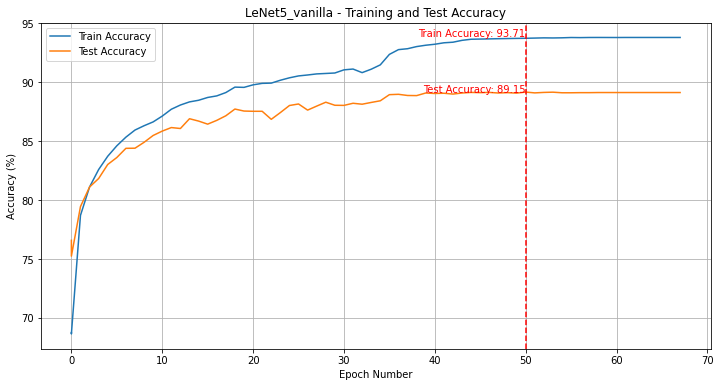

In [54]:
model_vanilla = LeNet5().to(device)
optimizer = optim.Adam(model_vanilla.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-6)

if not os.path.exists('model_LeNet5_vanilla.pth'):
    train_and_evaluate('LeNet5_vanilla',model_vanilla, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)    
    

model_vanilla = load_model_and_evaluate(model_vanilla, 'LeNet5_vanilla')

# 2. LeNet5 with Batch Normalization

Accuracy of model on test images: 91.22%


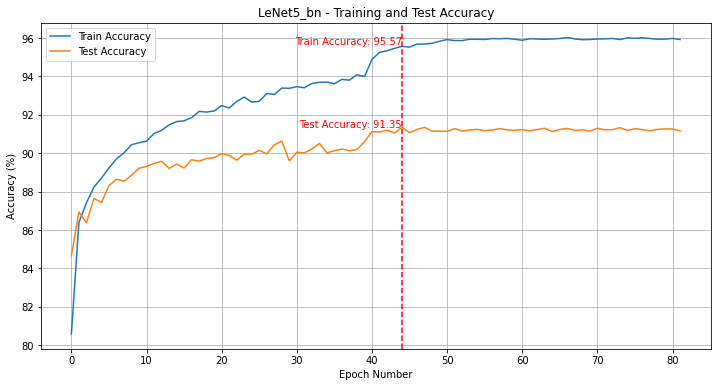

In [56]:
model_bn = LeNet5(use_batch_norm=True).to(device)
optimizer = optim.Adam(model_bn.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-7)

if not os.path.exists('model_LeNet5_bn.pth'):
    train_and_evaluate('LeNet5_bn', model_bn, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)
    

model_bn = load_model_and_evaluate(model_bn, 'LeNet5_bn')

# 3. LeNet5 with Dropout

Accuracy of model on test images: 89.88%


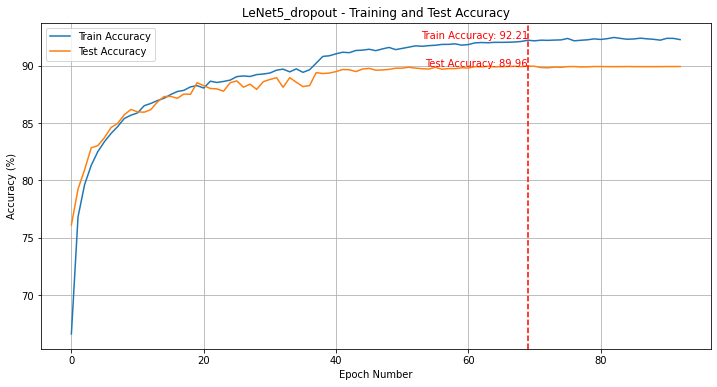

In [57]:
model_dropout = LeNet5(use_batch_norm=False, use_dropout=True, dropout_prob=0.35).to(device)
optimizer = optim.Adam(model_dropout.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-6)


if not os.path.exists('model_LeNet5_dropout.pth'):
    train_and_evaluate('LeNet5_dropout', model_dropout, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)
    

model_dropout = load_model_and_evaluate(model_dropout, 'LeNet5_dropout')

# 4. LeNet5 with Weight Decay

Accuracy of model on test images: 88.40%


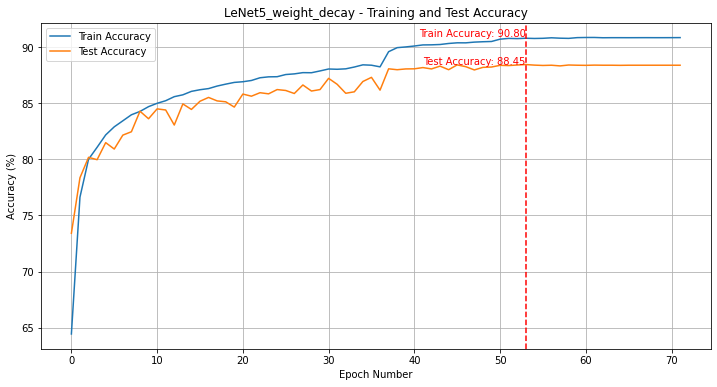

In [58]:
model_weight_decay = LeNet5(use_batch_norm=False).to(device)
optimizer = optim.Adam(model_weight_decay.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, min_lr=1e-6)
if not os.path.exists('model_LeNet5_weight_decay.pth'):
    train_and_evaluate('LeNet5_weight_decay', model_weight_decay, optimizer, scheduler, train_loader, val_loader, test_loader, epochs, device)
    

model_weight_decay = load_model_and_evaluate(model_weight_decay, 'LeNet5_weight_decay')